<a href="https://colab.research.google.com/github/JinkaiGUAN/PyTorch-Course/blob/master/transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!ls "/content/gdrive/My Drive/Pytorch_learning"

deep_learning_turkey.ipynb  hymenoptera_data  transferLearning.ipynb


In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
transform_mean = [0.485, 0.456, 0.406]
transform_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(size=224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=transform_mean, std=transform_std)
    ]),
    'val': transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=transform_mean, std=transform_std)
    ]),
}

data_dir = "/content/gdrive/My Drive/Pytorch_learning/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]) 
                                          for x in ['train', 'val']}
dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
class_names

['ants', 'bees']

## Visualize a few images

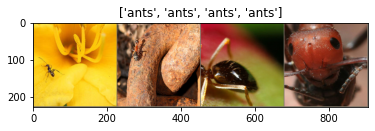

In [11]:
def imshow(inp, title=None):
    """
    Imshow for Iensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(transform_mean)
    std = np.array(transform_std)
    inp = std * inp + mean  # unnoemalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloader['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [0]:
?np.clip()

## Training The Model
1. scheduling the learning rate
2. saving teh best model

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('-' * 30)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to training mode
            else:
                model.eval()  # set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # model.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward, track the history id only in training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best val Acc:{:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



## Visualizing the model predictions

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[pred[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


## FineTunning the convnet

load a pretrained model and reset final fully connected layer

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# here teh size of each output sample is set to 2
# alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names))
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 1 / 25
------------------------------
train Loss: 0.3136 Acc: 0.8683
val Loss: 0.1842 Acc: 0.9281

Epoch 2 / 25
------------------------------
train Loss: 0.2634 Acc: 0.8971
val Loss: 0.1813 Acc: 0.9412

Epoch 3 / 25
------------------------------
train Loss: 0.3047 Acc: 0.8601
val Loss: 0.1727 Acc: 0.9412

Epoch 4 / 25
------------------------------
train Loss: 0.3225 Acc: 0.8683
val Loss: 0.1794 Acc: 0.9346

Epoch 5 / 25
------------------------------
train Loss: 0.3212 Acc: 0.8683
val Loss: 0.1971 Acc: 0.9150

Epoch 6 / 25
------------------------------
train Loss: 0.3594 Acc: 0.8765
val Loss: 0.1769 Acc: 0.9412

Epoch 7 / 25
------------------------------
train Loss: 0.3288 Acc: 0.8601
val Loss: 0.1763 Acc: 0.9477

Epoch 8 / 25
------------------------------
train Loss: 0.3243 Acc: 0.8724
val Loss: 0.1665 Acc: 0.9412

Epoch 9 / 25
------------------------------
train Loss: 0.3379 Acc: 0.8724
val Loss: 0.1704 Acc: 0.9608

Epoch 10 / 25
------------------------------
train Loss

In [21]:
device

device(type='cuda')

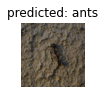

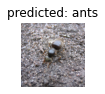

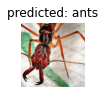

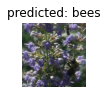

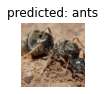

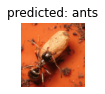

In [32]:
visualize_model(model_ft)